# Time Series with BentoML and Prophet

This notebook uses `BentoML` and `Kubeflow` to build, train and boot an api powered by a `Prophet` time series model. 

The below notebook focuses on building and serving a model using:
- [BentoML](https://github.com/bentoml/BentoML)
- Kubeflow [Fairing](https://www.kubeflow.org/docs/fairing/fairing-overview/) and [KFServe](https://github.com/kubeflow/kfserving)
- [Prophet](https://facebook.github.io/prophet/)

### Covid19 Data

The notebook uses the [Covid19 Kaggle locality infection data](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset#covid_19_data.csv) as our sample data. The notebook uses my home town `New York` as the locality.

In [196]:
%%capture

!pip install pandas sklearn auto-sklearn kubeflow-fairing grpcio kubeflow.metadata bentoml plotly fbprophet

In [197]:
import uuid
from importlib import reload
import grpc
from kubeflow import fairing
from kubeflow.fairing import constants
import os
import pandas as pd
import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

# Config

The values below will be used throughout this notebook, make sure to adjust these values to match your registry and namespace.

In [198]:
# The docker registry to store images in
DOCKER_REGISTRY = "iancoffey"
# The k8s namespace to run the experiment in
k8s_namespace = "default"

# Minio

This notebook will use Minio as the development context storage for `Kubeflow Fairing`, but any of the supported blob storage (s3, gcp, etc) will work.

To install Minio, apply the provided Minio manifest into the provided namespace.

`kubectl apply -f ./manifests/minio -n $k8s_namespace`

We will use the kubernetes sdk to determine the endpoints ip address and then build our `MinioContextSource`.

In [5]:
from kubernetes import utils as k8s_utils
from kubernetes import client as k8s_client
from kubernetes import config as k8s_config
from kubeflow.fairing.utils import is_running_in_k8s

from kubeflow.fairing.cloud.k8s import MinioUploader
from kubeflow.fairing.builders.cluster.minio_context import MinioContextSource

if is_running_in_k8s():
    k8s_config.load_incluster_config()
else:
    k8s_config.load_kube_config()

api_client = k8s_client.CoreV1Api()
minio_service_endpoint = api_client.read_namespaced_service(name='minio-service', namespace='default').spec.cluster_ip

In [19]:
minio_endpoint = "http://"+minio_service_endpoint+":9000"
minio_username = "minio"
minio_key = "minio123"
minio_region = "us-east-1"

minio_uploader = MinioUploader(endpoint_url=minio_endpoint, minio_secret=minio_username, minio_secret_key=minio_key, region_name=minio_region)
minio_context_source = MinioContextSource(endpoint_url=minio_endpoint, minio_secret=minio_username, minio_secret_key=minio_key, region_name=minio_region)
minio_endpoint

'http://10.152.183.6:9000'

# Start: Preparing the Dataset


To train our data, we need to split the data into train and test datasets as normal. We cant use the normal `train_test_split` function due to this being timeseries data, so we will have to define our own means of splitting the data by date.

In [209]:
# fairing:include-cell
data_path="covid_19_data.csv"
dframe = pd.read_csv(data_path, sep=',')

In [210]:
cols_of_interest = ['Confirmed', 'Province/State', 'ObservationDate']

dframe['ObservationDate'] = pd.to_datetime(dframe['ObservationDate'])
dframe.sort_index(inplace=True)

trimmed_dframe=dframe[cols_of_interest]
trimmed_dframe=trimmed_dframe.dropna()

# Note the copy() here - else we would be working on a reference
state_data = trimmed_dframe.loc[trimmed_dframe['Province/State'] == 'New York'].copy()
state_data = state_data.drop('Province/State', axis=1).sort_index()

state_data.rename(columns={'Confirmed': 'y', 'ObservationDate': 'ds'}, inplace=True)

state_data.head()

,y,ds
4549,173.0,2020-03-10
4755,220.0,2020-03-11
4964,328.0,2020-03-12
5356,421.0,2020-03-13
5411,525.0,2020-03-14


[W 200527 19:17:23 _axes:4222] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


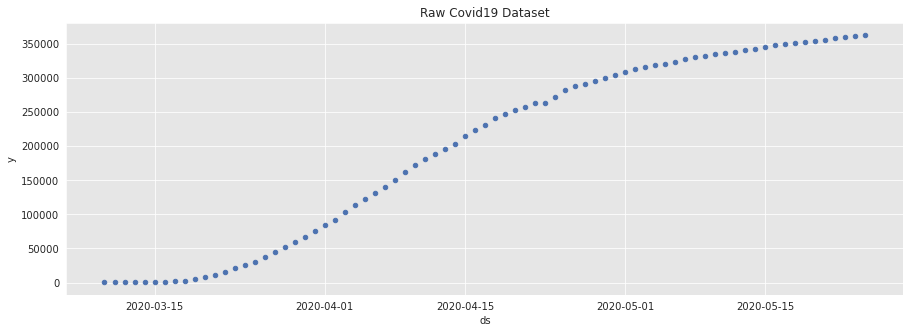

In [203]:
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]


_ = state_data.plot(x ='ds', y='y', kind='scatter', figsize=(15,5), title="Raw Covid19 Dataset")

In [272]:
split_date = "2020-05-15"

train_data = state_data[state_data['ds'] <= split_date].copy()
test_data = state_data[state_data['ds'] >  split_date].copy()

len(state_data)

77

# Model Training

Now that we have gathered and transformed our original covid19 timeseries data, we can create a new Prophet model and fit our training data.

Then, we can use [make_future_dataframe](https://rdrr.io/cran/prophet/man/make_future_dataframe.html) to create a dataframe to contain our future timeseries and predictions. We pass `periods` as 10 to ensure we have 10 days predicted.

In [205]:
# Python
import pandas as pd
from fbprophet import Prophet

m = Prophet()
m.fit(train_data)
future = m.make_future_dataframe(periods=10)
future.tail()

[I 200527 19:17:33 forecaster:919] Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[I 200527 19:17:33 forecaster:919] Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
72,2020-05-21
73,2020-05-22
74,2020-05-23
75,2020-05-24
76,2020-05-25


# Prediction

We can use our new model to forcast our future timeseries and plot the results.

In [211]:
import numpy as np

forecast = m.predict(future)
print(forecast['yhat'].tail())

72    362470.476200
73    365496.015175
74    369703.173415
75    372333.226614
76    374064.903150
Name: yhat, dtype: float64


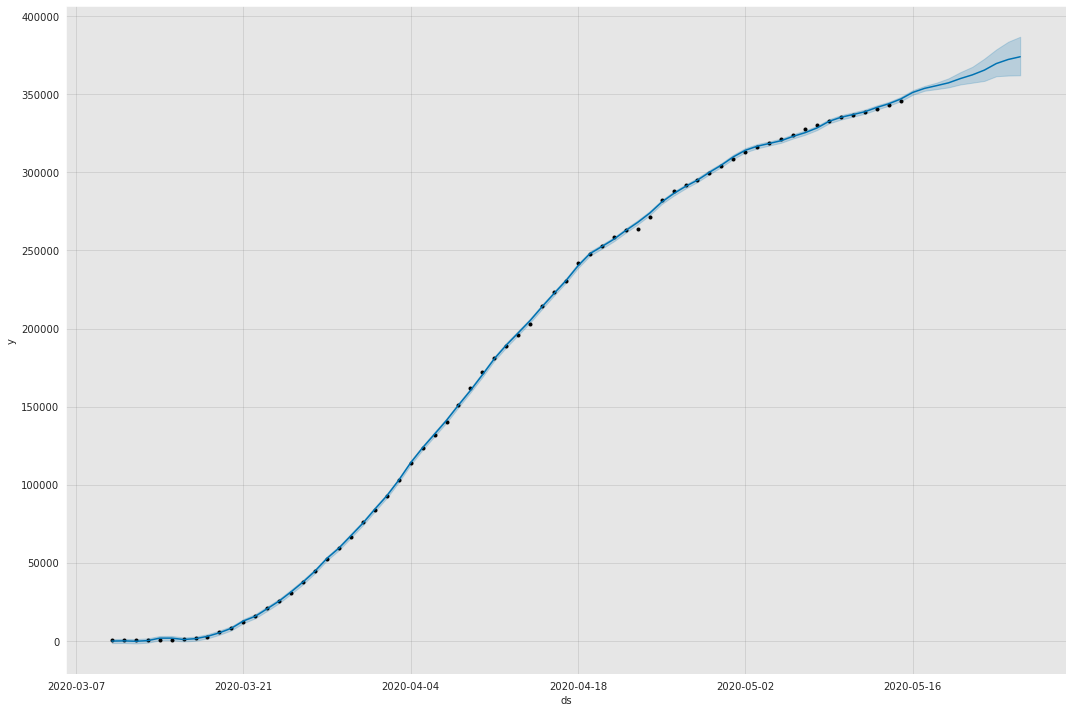

In [207]:
fig1 = m.plot(forecast, figsize = (15, 10))

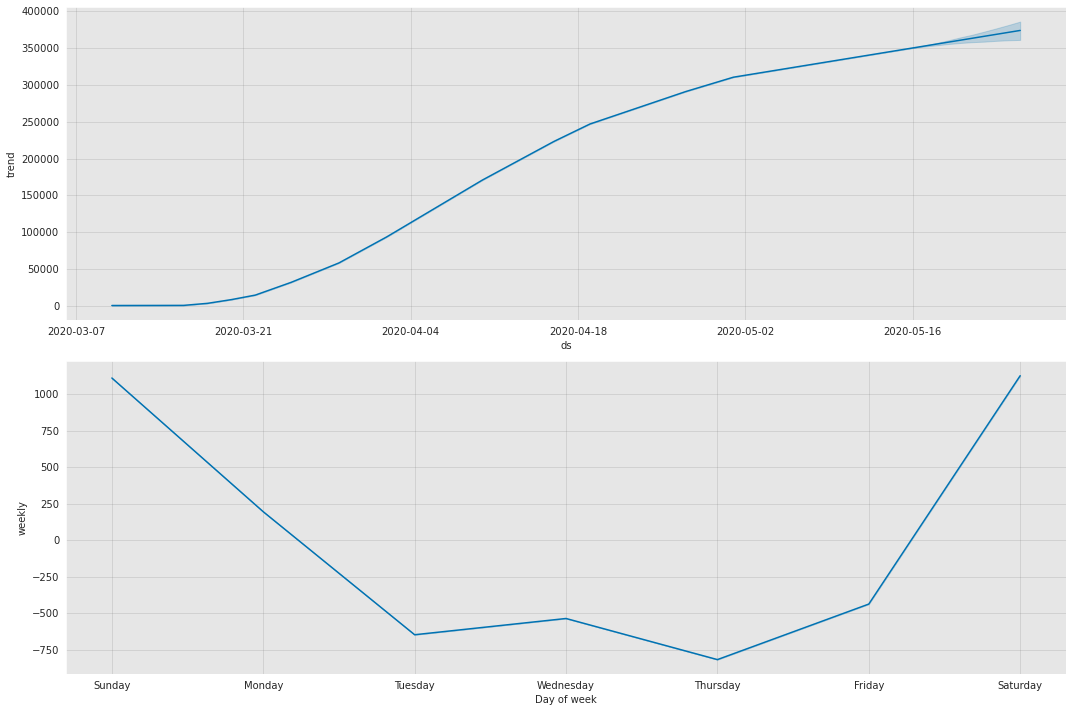

In [189]:
m.plot_components(forecast, figsize = (15, 10));

In [165]:
for c in forecast.columns.sort_values():
    print(c)

additive_terms
additive_terms_lower
additive_terms_upper
ds
multiplicative_terms
multiplicative_terms_lower
multiplicative_terms_upper
trend
trend_lower
trend_upper
weekly
weekly_lower
weekly_upper
yhat
yhat_lower
yhat_upper


# Projected vs Reality

It is helpful to plot our predictions alongside our test data set, divided into two sections of time, defined by the boundary of the training and test datasets. We can see that the predictions were a bit too aggresive.

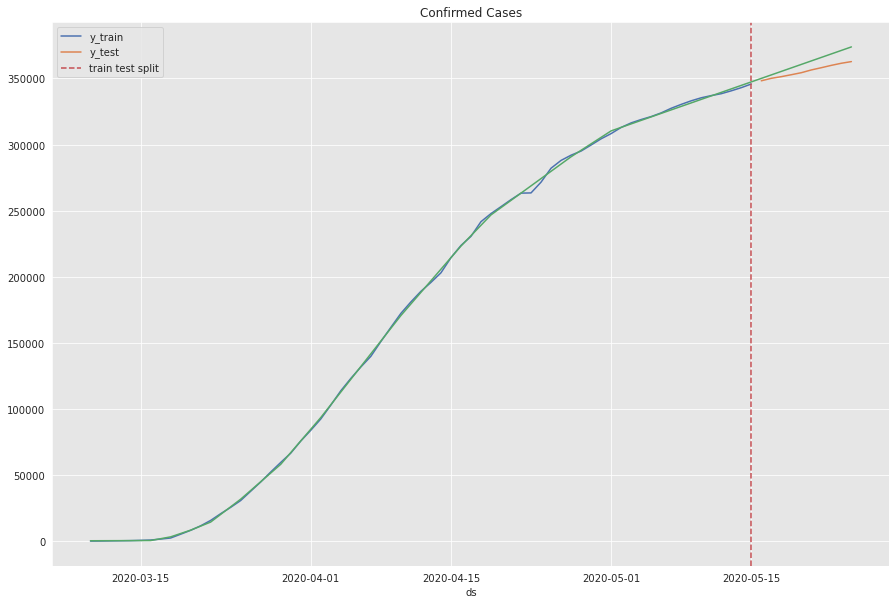

In [191]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

threshold_date = pd.to_datetime(split_date)

fig, ax = plt.subplots(figsize = (15, 10))
sns.lineplot(x='ds', y='y', label='y_train', data=train_data, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=test_data, ax=ax)
sns.lineplot(x='ds', y='trend', data=forecast, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Confirmed Cases', ylabel='');

# Define BentoML Service

We will now define the code we want to use to serve our model with BentoML.

Our class and methods will be decorated to shows its artifact type and pip dependencies.

Following that, lets reload the the new code and pack our BentoML service with the booster we have created!

In [192]:
%%writefile prophet_serve.py

import bentoml
from bentoml.handlers import DataframeHandler
from bentoml.artifact import PickleArtifact
import fbprophet

@bentoml.artifacts([PickleArtifact('model')])
@bentoml.env(pip_dependencies=['fbprophet'])
class ProphetServe(bentoml.BentoService):
    @bentoml.api(DataframeHandler)
    def predict(self, df):
        return self.artifacts.model.predict(df)

Overwriting prophet_serve.py


In [168]:
import prophet_serve
import importlib
importlib.reload(prophet_serve)

<module 'prophet_serve' from '/home/jovyan/prophet_serve.py'>

# Pack BentoML Service

Lets pack the new service with our model, which would allow use to reference this iteration in the future and also build it into Docker images.

In [169]:
from prophet_serve import ProphetServe

bento_service = ProphetServe()
bento_service.pack('model', m)
saved_path = bento_service.save()

[I 200527 14:36:24 migration:155] Context impl SQLiteImpl.
[I 200527 14:36:24 migration:162] Will assume non-transactional DDL.


[2020-05-27 14:36:39,218] INFO - BentoService bundle 'ProphetServe:20200527143624_5C1ABC' saved to: /home/jovyan/bentoml/repository/ProphetServe/20200527143624_5C1ABC


# BentoML Service

Now that we have a BentoML Service defined, lets checkout what that looks like via the cli:

In [170]:
!bentoml get ProphetServe

BENTO_SERVICE                       AGE                         APIS                       ARTIFACTS
ProphetServe:20200527143624_5C1ABC  1.77 second                 predict<DataframeHandler>  model<PickleArtifact>
ProphetServe:20200527143217_346214  4 minutes and 4.51 seconds  predict<DataframeHandler>  model<PickleArtifact>


# Explore the Bentoml service

Lets pick a service to launch as a service. We will use the most recent one here, but you will need to edit the values below to match yours. This is purely for convience so that we can poke at the BentoML CLI quickly.

We can see inside the autogenerated bento service directory that many files now exist, including a Dockerfile and requirements.txt

In [212]:
!bentoml get ProphetServe:20200527143624_5C1ABC

{
  "name": "ProphetServe",
  "version": "20200527143624_5C1ABC",
  "uri": {
    "type": "LOCAL",
    "uri": "/home/jovyan/bentoml/repository/ProphetServe/20200527143624_5C1ABC"
  },
  "bentoServiceMetadata": {
    "name": "ProphetServe",
    "version": "20200527143624_5C1ABC",
    "createdAt": "2020-05-27T14:36:39.149660Z",
    "env": {
      "condaEnv": "name: bentoml-ProphetServe\nchannels:\n- defaults\ndependencies:\n- python=3.7.6\n- pip\n",
      "pipDependencies": "bentoml==0.7.5\nfbprophet",
      "pythonVersion": "3.7.6"
    },
    "artifacts": [
      {
        "name": "model",
        "artifactType": "PickleArtifact"
      }
    ],
    "apis": [
      {
        "name": "predict",
        "handlerType": "DataframeHandler",
        "docs": "BentoService API",
        "handlerConfig": {
          "orient": "records",
          "typ": "frame",
          "is_batch_input": true,
          "input_dtypes": null,
          "output_orient": "records"
        }
      }
    ]
  }
}


# Run Bento Service

Now, using our BentoML service, we can make predictions like so:

In [215]:
!bentoml run ProphetServe:20200527143624_5C1ABC predict --input '{"ds":["2021-07-14"]}'

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
          ds         trend  ...  multiplicative_terms_upper          yhat
0 2021-07-14  1.471904e+06  ...                         0.0  1.471369e+06

[1 rows x 16 columns]


# Explore BentoML Generated Artifacts

BentoML generates a whole environment, including Dockerfile, for generating images based on these saved services.

It is useful to `ls` this directory and see what it contains.

In [218]:
!ls /home/jovyan/bentoml/repository/ProphetServe/20200527143624_5C1ABC

bentoml_init.sh       Dockerfile       ProphetServe	 setup.py
bentoml.yml	      environment.yml  README.md
docker-entrypoint.sh  MANIFEST.in      requirements.txt


# Stitching BentoML to Kubeflow Fairing

We can build our models container with Kubeflow Fairing, a cool component which aims to improve data scientist life by streamlining the process of building, training, and deploying machine learning (ML) models.

First we need to do some work to get the BentoML artifacts into our build context. We do this via the `preprocessing` work below. We are just taking the auto-generated `BentoML` Docker environment and stitching it together with `Kubeflow Fairing`.

In [242]:
# Let build a docker image with builder using bentoml output
from kubeflow.fairing.preprocessors.base import BasePreProcessor

output_map =  {
    "/home/jovyan/bentoml/repository/ProphetServe/20200527143624_5C1ABC/Dockerfile": "Dockerfile",
    "/home/jovyan/bentoml/repository/ProphetServe/20200527143624_5C1ABC/environment.yml": "environment.yml",
    "/home/jovyan/bentoml/repository/ProphetServe/20200527143624_5C1ABC/requirements.txt": "requirements.txt",
    "/home/jovyan/bentoml/repository/ProphetServe/20200527143624_5C1ABC/setup.py": "setup.py",
    "/home/jovyan/bentoml/repository/ProphetServe/20200527143624_5C1ABC/bentoml_init.sh": "bentoml_init.sh",
    "/home/jovyan/bentoml/repository/ProphetServe/20200527143624_5C1ABC/bentoml.yml": "bentoml.yml",
    "/home/jovyan/bentoml/repository/ProphetServe/20200527143624_5C1ABC/ProphetServe/": "ProphetServe/",
    "/home/jovyan/bentoml/repository/ProphetServe/20200527143624_5C1ABC/ProphetServe/prophet_serve.py": "ProphetServe/prophet_serve.py",
    "/home/jovyan/bentoml/repository/ProphetServe/20200527143624_5C1ABC/ProphetServe/artifacts/model.pkl": "ProphetServe/artifacts/model.pkl",
    "/home/jovyan/bentoml/repository/ProphetServe/20200527143624_5C1ABC/docker-entrypoint.sh": "docker-entrypoint.sh",    
}

preprocessor = BasePreProcessor(output_map=output_map)

preprocessor.preprocess()

set()

# Cluster Building

In this workflow, we want to develop our models locally, until we arrive at a model we want to deploy. From there we want to use cloud resources to build Docker images to deploy to our Kubernetes cluster.

These Docker images will be built in our private cloud, perhaps using data and artifacts which are sensitive in nature.

In [243]:

from kubeflow.fairing.builders import cluster
from kubeflow.fairing import constants

constants.constants.KANIKO_IMAGE = "gcr.io/kaniko-project/executor:v0.22.0"

cluster_builder = cluster.cluster.ClusterBuilder(registry=DOCKER_REGISTRY,
                                                 preprocessor=preprocessor,
                                                 dockerfile_path="Dockerfile",
                                                 context_source=minio_context_source)

print(cluster_builder.build())

[I 200601 16:02:16 cluster:46] Building image using cluster builder.
[I 200601 16:02:16 base:107] Creating docker context: /tmp/fairing_context_rm6_9f1z
[W 200601 16:02:16 base:94] Dockerfile already exists in Fairing context, skipping...
[W 200601 16:02:21 manager:296] Waiting for fairing-builder-kq4t6-76sbd to start...
[W 200601 16:02:21 manager:296] Waiting for fairing-builder-kq4t6-76sbd to start...
[I 200601 16:02:22 manager:302] Pod started running True


INFO[0001] Retrieving image manifest continuumio/miniconda3:4.8.2
INFO[0002] Retrieving image manifest continuumio/miniconda3:4.8.2
INFO[0003] Built cross stage deps: map[]
INFO[0003] Retrieving image manifest continuumio/miniconda3:4.8.2
INFO[0004] Retrieving image manifest continuumio/miniconda3:4.8.2
INFO[0004] Executing 0 build triggers
INFO[0004] Unpacking rootfs as cmd RUN set -x      && apt-get update      && apt-get install --no-install-recommends --no-install-suggests -y libpq-dev build-essential      && rm -rf /var/lib/apt/lists/* requires it.
INFO[0028] RUN set -x      && apt-get update      && apt-get install --no-install-recommends --no-install-suggests -y libpq-dev build-essential      && rm -rf /var/lib/apt/lists/*
INFO[0028] Taking snapshot of full filesystem...
INFO[0028] Resolving 19967 paths
INFO[0034] cmd: /bin/sh
INFO[0034] args: [-c set -x      && apt-get update      && apt-get install --no-install-recommends --no-install-suggests -y libpq-dev build-essential     

# Deploy the Service

There are several good ways we can deploy the model we have fit, trained and crafted into an image. For this example, we will deploy the model service with KFServing by creating an `InferenceService`. This project uses Knative Serving to deploy the service and setup its routes. Under the covers Istio is at work routing our traffic to this new service.

For local development, set the cluster local tags and set the domain to reflect `svc.cluster.local` as described in [these docs](https://knative.dev/docs/serving/cluster-local-route/).

Lets use the Custom Object K8S API to deploy the pickled Prophet model we have defined with BentoML and built with Fairing.

## KFServing `InferenceService`

Below, [we define and launch an inferenceservice](https://docs.bentoml.org/en/latest/deployment/kfserving.html#deploy-bentoservice-to-kfserving), which in turn reconciles into a Knative service.

In [252]:
image = cluster_builder.image_tag

inference_service = {
    "kind": "InferenceService",
    "apiVersion": "serving.kubeflow.org/v1alpha2",
    "metadata": {
        "name": "prophet-model-api",
        "controller-tools.k8s.io": "1.0",
        "labels": {"app": "secret"},
    },
    "spec": {
        "default": {
            "predictor":{
                "minReplicas": 1,
                "custom": {
                    "container": {
                        "image": image,
                        "ports": [
                            {
                                "containerPort": 5000,
                            }
                        ]
                    }
                }
            }
        }
    }
}

group = 'serving.kubeflow.org'
version = 'v1alpha2'
plural = 'inferenceservices'
custom_api_instance = k8s_client.CustomObjectsApi()

api_response = custom_api_instance.create_namespaced_custom_object(group, version, k8s_namespace, plural, inference_service, pretty=True)
print(api_response)

{'apiVersion': 'serving.kubeflow.org/v1alpha2', 'kind': 'InferenceService', 'metadata': {'creationTimestamp': '2020-06-01T17:10:44Z', 'generation': 1, 'labels': {'app': 'secret'}, 'name': 'prophet-model-api', 'namespace': 'default', 'resourceVersion': '1880249', 'selfLink': '/apis/serving.kubeflow.org/v1alpha2/namespaces/default/inferenceservices/prophet-model-api', 'uid': '08e3e088-f86d-4b55-bbe6-30b0bbd6edcb'}, 'spec': {'default': {'predictor': {'custom': {'container': {'image': 'iancoffey/fairing-job:C7EC5C2', 'name': '', 'ports': [{'containerPort': 5000}], 'resources': {'limits': {'cpu': '1', 'memory': '2Gi'}, 'requests': {'cpu': '1', 'memory': '2Gi'}}}}, 'minReplicas': 1}}}, 'status': {}}


# Querying the Inference Server

Now we are ready to use our endpoint. Lets post a test date with curl and see our shiny brand new API endpoint perform.

In [269]:
!curl -i --header "Content-Type: application/json" -X POST http://prophet-model-api-predictor-default-mskn6-private.default.svc.cluster.local/predict --data '{"ds":["2020-07-14"]}' 










[{"ds":1594684800000,"trend":506162.6572053498,"yhat_lower":298790.7931327721,"yhat_upper":702144.4737470886,"trend_lower":298549.3033376507,"trend_upper":702959.0456289337,"additive_terms":-645.3873742295,"additive_terms_lower":-645.3873742295,"additive_terms_upper":-645.3873742295,"weekly":-645.3873742295,"weekly_lower":-645.3873742295,"weekly_upper":-645.3873742295,"multiplicative_terms":0.0,"multiplicative_terms_lower":0.0,"multiplicative_terms_upper":0.0,"yhat":505517.2698311203}]

# Model Deployed

Now we have a fitted and trained a model, defined a Service with BentoML, built an image for it using Kubeflow Fairing and deployed it to our Kubernetes dev cluster with KFServing. Party!